In [1]:
from palmari import Experiment
from palmari.processing import TifPipeline

from os.path import join
import mrc

from pathlib import Path

import pandas as pd
import numpy as np
import napari as na

import matplotlib.pyplot as plt

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [2]:
tp_file = r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\tracking parameters\2023-06-29__rois_g-r_radsym_cons.yaml'
tp = TifPipeline.from_yaml(tp_file)
tp.name = Path(tp_file).stem

{'FindRois': {'movie_file': 'E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 1\\DK5082_1525gfst_250ms_1min_004.dv', 'rois_file_pattern': '_seg.npy', 'rois_fmt': 'cellpose'}}
{'GodinezRohr': {'c': 1.0, 'eccentricity': 0.9, 'max_spot_size': 6.0, 'min_spot_size': 2.5, 'show_log': True, 'show_mask': False, 'sigma': 1.5}}
{'RadialLocalizer': {'window_size': 6}}
{'ConservativeTracker': {'max_diffusivity': 0.05}}


In [3]:
# specify folders containing movies to be process
folders = [
    r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Small Batch Water\BR1',
    r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Small Batch Water\BR2',
    r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Small Batch Water\BR3',
]

file_pattern = '*.dv' # dv = deltavision

# define experimental parameters
delta_t = 0.25 # seconds
pixel_size = 40.27 / 512 # um
 
# loop over folders processing each movie
for folder in folders:
    exp = Experiment(data_folder=folder,
                 export_folder=folder,
                 DT=delta_t,
                 pixel_size=pixel_size,
                 file_pattern=file_pattern)
    
    tp.process(exp, force_reprocess=True)

Frame 240: 487 trajectories present.


In [110]:
folder = r'E:\Data\Kearns\TIRF from Caroline in Kearns Lab Caroline Dunn\Strain Comparison\Strains Bio Rep 3'
subfolder = r'2023-06-21_g-r_radsym_cons'
fname = r'DK1906_1525gfst_250ms1min_003'
ext = '.dv'

movie = mrc.imread(join(folder, fname+ext))
tracks = pd.read_csv(join(folder, subfolder, fname+'.locs'), index_col=0)

In [111]:
min_locs = 20
tracks_grouped  = tracks.groupby('n')
tracks_filt = tracks_grouped.filter(lambda x: (x['n'].count() >= min_locs))

In [51]:
viewer = na.Viewer()

In [112]:
viewer.add_image(movie, scale=(1, pixel_size, pixel_size), name = fname + ' movie')

viewer.add_tracks(
                data=tracks_filt[['n','frame','x','y']],
                tail_width=3,
                tail_length=50,
                head_length=0,
                # features=tracks_wt[['n','frame','x','y']],
                # features={'n': tracks_wt['n']},
                properties={'n': tracks_filt['n'].values},
                color_by='n',
                name = fname + ' tracks',
            )

C:\Users\djfoust\Anaconda3\envs\napari-env\lib\site-packages\napari\layers\tracks\tracks.py:617: UserWarning: Previous color_by key 'n' not present in features. Falling back to track_id
  warn(


<Tracks layer 'DK1906_1525gfst_250ms1min_003 tracks' at 0x21c935c96d0>

In [41]:
(4 * 35 / np.pi)**0.5

6.6755811781245455

In [38]:
np.pi * 6**2 / 4

28.274333882308138

In [54]:
def calc_msd_hist(filename, min_locs,
                 pixel_scale, tau, max_lag,
                 bins):
    """
    Generate histogram of D_app as determined by fitting mean squared displacements
    """
    data = pd.read_csv(filename, index_col=0)
    track_ids = np.unique(data['n'])
    
    D_app = []
    track_ids_D = []
    id2nlocs = {}
    
    for tid in track_ids:

        track_filt = data['n'] == tid
        n_locs = track_filt.sum()

        if n_locs >= min_locs:
            frames = data['frame'][track_filt].values
            rows = data['y'][track_filt].values
            cols = data['x'][track_filt].values
            id2nlocs[tid] = n_locs

            for i in range(0, n_locs-min_locs+1):
                frames_seg = frames[i:i+min_locs]
                rows_seg = rows[i:i+min_locs]
                cols_seg = cols[i:i+min_locs]

                D_app.append(calc_msd(frames_seg, rows_seg, cols_seg, pixel_scale, tau, max_lag))
                track_ids_D.append(tid)

    D_app = np.array(D_app)
    track_ids_D = np.array(track_ids_D)
    
    D_app_bs = []

    for ti in np.unique(track_ids_D):
        n_segs = id2nlocs[ti] // min_locs
        D_app_ti = D_app[track_ids_D == ti]
        D_app_ti_samp = np.random.choice(D_app_ti, size=n_segs)
        D_app_bs.append(D_app_ti_samp)

    D_app_bs = np.concatenate(D_app_bs)
    
    p, plims = np.histogram(D_app_bs, bins=bins)
    
    return p, plims

def calc_msd(frames, rows, cols, pixel_size, tau, max_lag):
    """
    Calculate D_app by fitting line to mean squared displacements 
    """
    n_locs = len(frames)
    
    msd_num = np.zeros(max_lag+1)
    msd_den = np.zeros(max_lag+1)
    
    for offset in range(1,n_locs):
        dFrame = frames[offset:] - frames[:-offset]
        sd = ((rows[offset:] - rows[:-offset])**2 + (cols[offset:] - cols[:-offset])**2) * pixel_size**2 # squared displacement, um^2
        msd_num += np.histogram(dFrame,
                                bins=np.arange(1, max_lag+3),
                                weights=sd)[0] # numerator of mean squared displacement
        msd_den += np.histogram(dFrame,
                                bins=np.arange(1, max_lag+3))[0] # denominator of mean squared displacement
        
    msd_num = msd_num[:-1]
    msd_den = msd_den[:-1]
        
    non_empty_lags = msd_den > 0
    msd = (msd_num[non_empty_lags] / msd_den[non_empty_lags]) # * (pixel_size)**2 # um^2

    lags_frame = np.arange(1, max_lag+1)[non_empty_lags] # frames
    lags_time = lags_frame * tau # seconds
    
    msd_den = msd_den[non_empty_lags]
    sum_w = msd_den.sum()
    sum_wxy = (msd_den * lags_time * msd).sum()
    sum_wx = (msd_den * lags_time).sum()
    sum_wy = (msd_den * msd).sum()
    sum_wx2 = (msd_den * lags_time**2).sum()
    
    D_app = 0.25 * (sum_w*sum_wxy - sum_wx*sum_wy) / (sum_w*sum_wx2 - sum_wx**2)
                                                
    return D_app

In [140]:
folder = r'E:\Data\Kearns\TIRF from Caroline in Kearns Lab Caroline Dunn\Strain Comparison\Strains Bio Rep 1\2023-06-21_g-r_radsym_cons'
fname1 = r'DK1906_1525gfst_250ms_1min_001.locs'
fname2 = r'DK1906_1525gfst_250ms_1min_002.locs'
fname3 = r'DK1906_1525gfst_250ms_1min_003.locs'
fname4 = r'DK1906_1525gfst_250ms_1min_004.locs'
fname5 = r'DK1906_1525gfst_250ms_1min_005.locs'
fname6 = r'DK1906_1525gfst_250ms_1min_006.locs'

fnames = [fname1, fname2, fname3, fname4, fname5, fname6]

min_locs = 20
pixel_scale = 1
tau = 0.25
max_lag = 19
bins = np.arange(-0.004, 0.025, 0.0001)


# p1, plims = calc_msd_hist(join(folder, fname1), min_locs,
#                  pixel_scale, tau, max_lag,
#                  bins)

# p2, plims = calc_msd_hist(join(folder, fname2), min_locs,
#                  pixel_scale, tau, max_lag,
#                  bins)
p = {}

for i, fn in enumerate(fnames):
    p[i+1] = calc_msd_hist(join(folder, fn), min_locs,
                 pixel_scale, tau, max_lag,
                 bins)

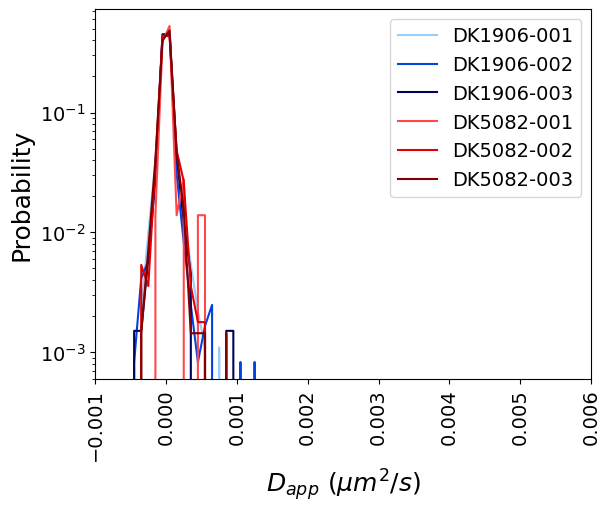

In [141]:
x = (p[1][1][:-1]+p[1][1][1:])/2

fig, ax = plt.subplots(1,1)
ax.plot(x, p[1][0]/p[1][0].sum(), label='DK1906-001', color='xkcd:light blue')
ax.plot(x, p[2][0]/p[2][0].sum(), label='DK1906-002', color='xkcd:blue')
ax.plot(x, p[3][0]/p[3][0].sum(), label='DK1906-003', color='xkcd:dark blue')
ax.plot(x, p[4][0]/p[4][0].sum(), label='DK5082-001', color='xkcd:light red')
ax.plot(x, p[5][0]/p[5][0].sum(), label='DK5082-002', color='xkcd:red')
ax.plot(x, p[6][0]/p[6][0].sum(), label='DK5082-003', color='xkcd:dark red')
ax.set_xlim([-0.001, 0.006])
plt.legend(fontsize=14)
ax.set_yscale('log')

plt.xlabel(r'$D_{app}\ (\mu m^2/s)$', fontsize=18)
plt.ylabel('Probability', fontsize=18)

plt.xticks(fontsize=14, rotation='vertical')
plt.yticks(fontsize=14);

In [142]:
bnd = 0.0002

print(
    p[1][0][x>=bnd].sum() / p[1][0].sum(),
    p[2][0][x>=bnd].sum() / p[2][0].sum(),
    p[3][0][x>=bnd].sum() / p[3][0].sum(),
)

0.022950819672131147 0.017341040462427744 0.021052631578947368


In [143]:
print(
    p[4][0][x>=bnd].sum() / p[4][0].sum(),
    p[5][0][x>=bnd].sum() / p[5][0].sum(),
    p[6][0][x>=bnd].sum() / p[6][0].sum(),
)

0.05555555555555555 0.033807829181494664 0.021551724137931036
